# Homework 3: Mining Data Streams

Below is the report and code for **HW3: Mining Data Streams**.  
The report follows the style of the Homework 2 excerpt above. For each class implemented in the code, a theoretical recall (short summary of the algorithm and the quantities involved) is given, followed by the implementation and a small runnable demonstration.

All content is in **English**.

## Reservoir Sampling — Theoretical Recall

**Goal.** Maintain a uniform random sample of *s* items from a stream of unknown and potentially large length *n* (where *n* grows over time). The reservoir sampling algorithm (often called R) ensures that at any time, each of the seen items has equal probability of being present in the reservoir.

**Key quantities / variables used in the implementation:**
- `s` — reservoir size (number of samples to keep).
- `samples` — the array (length `s`) storing the current sample elements; unfilled slots are initialized to a sentinel (here `-1`).
- `n` — number of items processed so far from the stream.

**Algorithm sketch (Reservoir Sampling):**
1. Fill the reservoir with the first `s` elements.
2. For each subsequent element with global index `i` (1-based) > `s`, draw a random integer `r` in `[1, i]`.  If `r <= s`, replace a random position in the reservoir with the new element. Otherwise, ignore the new element.

This ensures each item seen so far has probability `s / n` to be in the reservoir after processing `n` items.

In [6]:
import numpy as np

class Reservoir:
    def __init__(self, s):
        self.s = int(s)
        self.samples = -1 * np.ones(self.s, dtype=int)
        self.n = 0  # number of items processed

    def resetSampleSize(self, newS):
        if newS is not None:
            print(f"Setting new sample size to {newS}")
            self.s = int(newS)
        print("Resetting samples queue")
        self.samples = -1 * np.ones(self.s, dtype=int)
        self.n = 0

    def resampleFromIncomingData(self, incomingData):
        for elem in incomingData:
            if self.n < self.s:
                self.samples[self.n] = elem
            else:
                rdm = np.random.randint(1, self.n + 2)
                if rdm <= self.s:
                    index = np.random.randint(0, self.s)
                    self.samples[index] = elem
            self.n += 1

    def getSamples(self):
        return self.samples.copy(), int(self.n)

In [7]:
# Quick demonstration of Reservoir sampling
res = Reservoir(4)
res.resampleFromIncomingData([1, 5, 6, 2])
print('After first batch:', res.getSamples())
res.resampleFromIncomingData([1,3,4,5,6,7,8,9])
print('After second batch:', res.getSamples())

After first batch: (array([1, 5, 6, 2]), 4)
After second batch: (array([1, 3, 6, 1]), 12)


## TRIÈST (Base) — Theoretical Recall

**Problem.** Estimate the number of triangles in a large graph seen as an **edge stream** (only insertions). Exact counting is expensive; TRIÈST is a streaming algorithm that keeps a fixed-size sample of edges and updates triangle counts using those edges.

**Key variables:**
- `M` — maximum sample size (number of edges kept).
- `samples` — list of sampled edges (each edge is a 2-list or tuple `[u, v]`).
- `t` — global count of processed elements (edges) from the stream.
- `tau` — global estimated count of triangles (incremented/decremented on sample changes).
- `tau_local` — dictionary mapping a vertex to its local triangle count contribution.

**Key functions:**
- `sampleEdge` — decides whether a new edge enters the sample (when `t > M` it does with probability `M / t`).
- `updateCounters` — when an edge is added or removed from the sample, counters are updated for triangles that become present or absent in the sample.

**High level idea.** When a new edge arrives:
- If the sample is not full, insert it and update counters.
- If the sample is full, insert the edge with probability `M / t`, and if you insert it, evict a uniformly random edge from the sample — adjust counts accordingly.

### Structure of the Stream Elements

Each element of the input stream is represented as a tuple:

- **`bool`** (the *flag*)  
  A boolean value indicating the type of update applied to the graph:  
  - `True`  → the edge `[u, v]` must be **inserted**  
  - `False` → the edge `[u, v]` must be **deleted**

- **`[u, v]`**  
  An unordered pair of vertices representing the edge concerned by the update.  
  Since the graph is undirected, `[u, v]` is equivalent to `[v, u]`.

This means that each stream element corresponds to a *dynamic modification* of the graph: either adding or removing an edge. Algorithms such as **TRIÈST-Base** and **TRIÈST-Fully-Dynamic** process these updates sequentially while maintaining triangle count estimations on the evolving graph.


In [8]:
import numpy as np

class TriestBase:
    def __init__(self, M):
        print('TriestBase algorithm')
        self.M = int(M)
        self.samples = []
        self.t = 0
        self.tau = 0
        self.tau_local = {}

    def triestBase(self, stream):
        for elem in stream:
            if elem[0]:
                UV = elem[1]
                self.t += 1
                if self.sampleEdge(UV):
                    self.samples.append(UV)
                    self.updateCounters(UV, True)

    def sampleEdge(self, UV):
        if self.t <= self.M:
            return True
        elif np.random.randint(1, self.t + 1) <= self.M:
            index = np.random.randint(0, self.M)
            UVprime = self.samples[index]
            self.samples.pop(index)
            self.updateCounters(UVprime, False)
            return True
        return False

    def updateCounters(self, UV, add):
        interNeighbours = self.findNeighbours(UV)
        delta = 1 if add else -1
        for c in interNeighbours:
            self.tau += delta
            self.tau_local[c] = self.tau_local.get(c, 0) + delta
            self.tau_local[UV[0]] = self.tau_local.get(UV[0], 0) + delta
            self.tau_local[UV[1]] = self.tau_local.get(UV[1], 0) + delta

    def findNeighbours(self, UV):
        neighU = []
        neighV = []
        for sample in self.samples:
            if np.isin(UV[0], sample):
                temp = np.array(sample)
                maskU = np.isin(temp, UV[0], invert=True)
                neighU.append(temp[maskU].item())
            if np.isin(UV[1], sample):
                temp = np.array(sample)
                maskV = np.isin(temp, UV[1], invert=True)
                neighV.append(temp[maskV].item())
        if len(neighU) == 0 or len(neighV) == 0:
            return []
        inter = np.isin(neighU, neighV)
        if np.sum(inter) == 0:
            return []
        neighU = np.array(neighU)
        return neighU[inter].tolist()

    def setSamples(self, samplesList): #testing only
        self.samples = samplesList

In [9]:
# Tiny TRIÈST-Base demonstration
countTriangle = TriestBase(6)
streamingEdges = [
    (True,[1,2]), (True,[2,5]), (True,[5,4]), (True,[4,1]),
    (True,[1,3]), (True,[3,5]), (True,[4,6]), (True,[3,4])
]
countTriangle.triestBase(streamingEdges)
print('Sampled edges:', countTriangle.samples)
print('Local triangle counts:', countTriangle.tau_local)
print('Global tau (sample-based):', countTriangle.tau)

TriestBase algorithm
Sampled edges: [[1, 2], [2, 5], [5, 4], [4, 1], [1, 3], [3, 5]]
Local triangle counts: {}
Global tau (sample-based): 0


## TRIÈST (Fully-Dynamic) — Theoretical Recall

TRIÈST-FD supports fully dynamic edge streams where edges can be both inserted and deleted. The algorithm maintains an edge sample and uses counters to correct for bias due to deletions and insertions.

**Key quantities / variables:**
- `M` — sample capacity (number of edges to keep).
- `samples` — stored list of edges currently in the sample.
- `t` — number of elements seen (insertions + deletions processed so far).
- `tau`, `tau_local` — global and local triangle counters (adjusted when edges enter or leave the sample).
- `s` — current number of active edges in the graph (tracked by increment/decrement on insert/delete).
- `di` — bookkeeping counter for how many deletions were sampled.
- `do` — bookkeeping counter for how many deletions were observed but not present in the sample.

TRIÈST-FD uses a more complex sampling decision that considers the history of deletions and insertions; it keeps the sample approximately unbiased and adjusts counts when edges are removed from or added to the sample.

In [10]:
import numpy as np

class TriestFullyDynamic:
    def __init__(self, M):
        print('Triest Fully-Dynamic algorithm')
        self.M = int(M)
        self.samples = []
        self.t = 0
        self.tau = 0
        self.tau_local = {}
        self.s = 0
        self.do = 0
        self.di = 0

    def triestFullyDynamic(self, stream):
        for elem in stream:
            self.t += 1
            if elem[0]:
                self.s += 1
            else:
                self.s -= 1
            UV = elem[1]
            if elem[0]:
                if self.sampleEdge(UV):
                    self.updateCounters(UV, True)
            else:
                index = self.samplesContain(UV)
                if index >= 0:
                    self.updateCounters(UV, False)
                    self.samples.pop(index)
                    self.di += 1
                else:
                    self.do += 1

    def samplesContain(self, UV):
        for i, sample in enumerate(self.samples):
            if sample == UV:
                return i
        return -1

    def sampleEdge(self, UV):
        if self.do + self.di == 0:
            if len(self.samples) < self.M:
                self.samples.append(UV)
                return True
            elif np.random.randint(1, self.t + 1) <= self.M:
                index = np.random.randint(0, self.M)
                ZW = self.samples[index]
                self.updateCounters(ZW, False)
                self.samples.pop(index)
                self.samples.append(UV)
                return True
        elif (np.random.randint(1, self.di + self.do + 1) <= self.di):
            self.samples.append(UV)
            self.di -= 1
            return True
        else:
            self.do -= 1
            return False

    def updateCounters(self, UV, add):
        interNeighbours = self.findNeighbours(UV)
        delta = 1 if add else -1
        for c in interNeighbours:
            self.tau += delta
            self.tau_local[c] = self.tau_local.get(c, 0) + delta
            self.tau_local[UV[0]] = self.tau_local.get(UV[0], 0) + delta
            self.tau_local[UV[1]] = self.tau_local.get(UV[1], 0) + delta

    def findNeighbours(self, UV):
        neighU = []
        neighV = []
        for sample in self.samples:
            if np.isin(UV[0], sample):
                temp = np.array(sample)
                maskU = np.isin(temp, UV[0], invert=True)
                neighU.append(temp[maskU].item())
            if np.isin(UV[1], sample):
                temp = np.array(sample)
                maskV = np.isin(temp, UV[1], invert=True)
                neighV.append(temp[maskV].item())
        if len(neighU) == 0 or len(neighV) == 0:
            return []
        inter = np.isin(neighU, neighV)
        if np.sum(inter) == 0:
            return []
        neighU = np.array(neighU)
        return neighU[inter].tolist()

    def setSamples(self, samplesList):
        self.samples = samplesList

In [11]:
# Tiny TRIÈST-FD demonstration mixing insertions and deletions
stream = [
    (True,[1,2]), (True,[2,3]), (True,[1,3]),  # create triangle (1,2,3)
    (False,[2,3]),  # deletion of a triangle edge
    (True,[2,3]),   # re-insertion
]
TFD = TriestFullyDynamic(10)
TFD.triestFullyDynamic(stream)
print('Sampled edges:', TFD.samples)
print('tau_local:', TFD.tau_local)
print('tau:', TFD.tau)

Triest Fully-Dynamic algorithm
Sampled edges: [[1, 2], [1, 3], [2, 3]]
tau_local: {2: 1, 1: 1, 3: 1}
tau: 1



### The optional task for an extra bonus

### Challenges Faced When Implementing the Algorithm

One of the first difficulties was understanding the notation and update rules of the **TRIÈST-Fully-Dynamic** algorithm. The pseudocode uses compact mathematical notation (especially for the update of counters and the sampling probability), which made it difficult to translate directly into code.

For this reason, we initially implemented **TRIÈST-Base**, since it only handles insertions and involves fewer mechanisms. Working on the base version helped us clarify several important concepts:

- how to maintain the **reservoir** of sampled edges,
- how to compute **local triangle counts** efficiently,
- how to update global and local counters consistently,
- how to determine whether an edge currently belongs to the sample.

Once these components were tested and validated on small example streams, we extended the implementation to **TRIÈST-Fully-Dynamic**, which required additional logic for deletions, symmetric counter updates, and ensuring consistency when an edge leaves the reservoir.

---

### Can the Algorithm Be Easily Parallelized?

**TRIÈST is not easily parallelizable**, mainly for the following reasons:

1. **Single Shared Reservoir**  
   The algorithm relies on a *single* fixed-size reservoir.  
   Parallel updates would require multiple threads or machines to modify this shared reservoir, leading to race conditions, overwritten entries, and broken sampling invariants.

2. **Strict Ordering of Stream Updates**  
   TRIÈST’s probabilistic decisions depend on the **time step `t`**.  
   Splitting the stream across workers would destroy the global ordering, making the sampling probabilities invalid.

3. **Counter Dependencies**  
   Triangle counters must be updated immediately and consistently for every edge operation.  
   Parallel updates would require heavy synchronization or locking, removing most of the benefits of parallelization.


**Core algorithm is inherently sequential** because of its reliance on a shared reservoir and strict stream order.

---

### Does the Algorithm Work for Unbounded Graph Streams?

Yes. TRIÈST is explicitly designed to support **unbounded graph streams**, meaning that the stream may grow indefinitely. This is possible thanks to:

- **Reservoir sampling**, which stores a *fixed-size* subset of edges regardless of the total stream length.
- **Bounded memory usage**, which does not depend on the number of processed edges.


---

### Does the Algorithm Support Edge Deletions?

**TRIÈST-Base does not support deletions.**  
It assumes an insert-only stream because:

- the sampling scheme does not specify how to remove edges from the sample,
- triangle counters only increase and never decrease,
- the reservoir would no longer represent the current state of the graph if deletions occurred.

To handle deletions, the algorithm must be replaced by **TRIÈST-Fully-Dynamic**, which adds:

- symmetric rules for insertions and deletions,
- deletion-aware updates to triangle counters,
- logic to remove edges from the reservoir when necessary,
- probability functions that maintain unbiasedness even with deletions.

This extended version is required for supporting fully dynamic graph streams.



In [22]:
"""
probDelete tune the proportion of "+" and "-" in element stream
"""

def getData(file : str, splitterChar: str, probDelete:float = 0):
    output = []
    with open(file, "r") as f:
        for line in f:
            row = list(map(int, line.split(splitterChar)))
            boolean = False
            if np.random.randint(1,101) <= int(100*(1-probDelete)) :
                boolean = True
            output.append((boolean,row))
    return output


data25k = getData('data/lab3data.txt',None,1)
data500k = getData('data/HR_edges.txt',",",1)
data120k = getData('data/RO_edges.txt',",",1)
data220k = getData('data/HU_edges.txt',",",1)


### Computation time simulation

link to data, undirected graph
https://snap.stanford.edu/data/ca-GrQc.html
https://snap.stanford.edu/data/gemsec-Deezer.html


Triest Fully-Dynamic algorithm
number of edges=28980
number of edges=498202
number of edges=125826
number of edges=222887


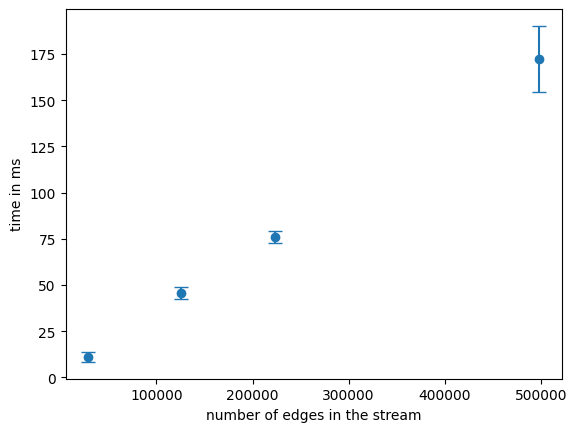

In [20]:
import matplotlib.pyplot as plt
import time as t

times = []
stds = []
TFD = TriestFullyDynamic(100)

datas=[data25k,data500k,data120k,data220k]
datasLenght=[]

for data in datas:
    print(f'number of edges={len(data)}')
    datasLenght.append(len(data))
    temp = []
    for i in range(1000):
        e = t.time()
        TFD.triestFullyDynamic(data)
        temp.append((t.time()-e)*1000)
    times.append(np.mean(temp))
    stds.append(np.std(temp))

plt.errorbar(datasLenght, times, yerr=stds, fmt='o', capsize=5)
plt.xlabel("number of edges in the stream")
plt.ylabel("time in ms")
plt.show()

number of samples=100
Triest Fully-Dynamic algorithm
number of samples=1000
Triest Fully-Dynamic algorithm
number of samples=10000
Triest Fully-Dynamic algorithm


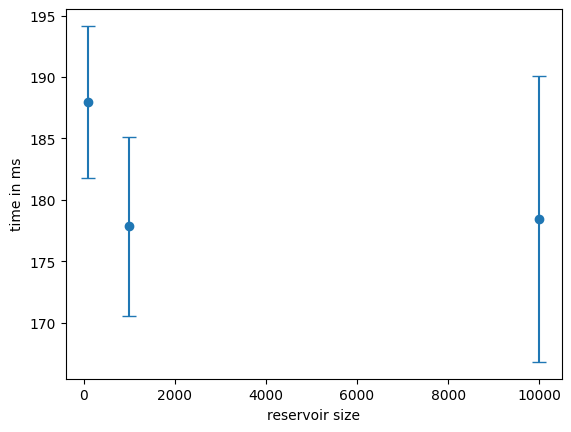

In [24]:
times = []
stds = []
sampledSizes = [100,1000,10000]

for i in sampledSizes:
    print(f'number of samples={i}')
    TFD = TriestFullyDynamic(i)
    temp = []
    for i in range(100):
        e = t.time()
        TFD.triestFullyDynamic(data500k)
        temp.append((t.time()-e)*1000)
    times.append(np.mean(temp))
    stds.append(np.std(temp))

plt.errorbar(sampledSizes, times, yerr=stds, fmt='o', capsize=5)
plt.xlabel("reservoir size")
plt.ylabel("time in ms")
plt.show()